# Import Necessary Python Libraries

In [17]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import wave
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential 
from keras.layers import  Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import itertools
from sklearn.metrics import confusion_matrix
labels=['down', 'go', 'unknown', 'up', 'on', 'left', 'no', 'off', 'right', 'silence', 'stop', 'yes']
file_path="audio"
max_pad_length=40
random_state=42

In [1]:
print (random_state)

NameError: name 'random_state' is not defined

# Audio visualizations

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


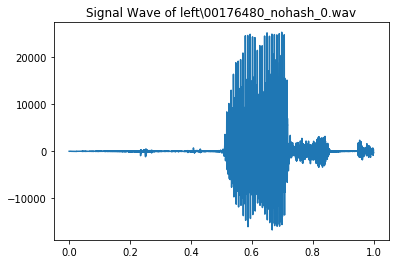

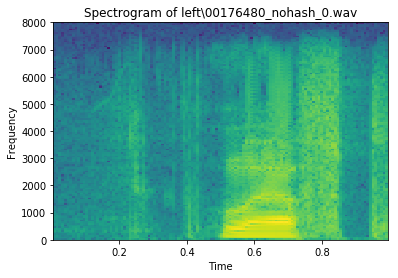

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


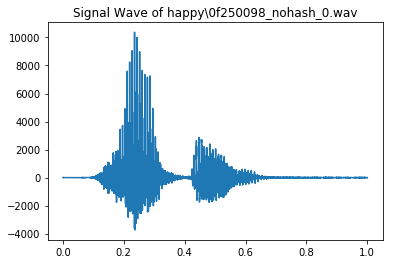

In [18]:

spf = wave.open('left/00176480_nohash_0.wav','r')

#Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')
fs = spf.getframerate()

#If Stereo
if spf.getnchannels() == 2:
    print ('Just mono files')
    sys.exit(0)


Time=np.linspace(0, len(signal)/fs, num=len(signal))

p=plt.figure(1)
plt.title('Signal Wave of left\\00176480_nohash_0.wav')
plt.plot(Time,signal)
plt.show()

p.savefig('signal.png')

plt.close()
samplingFrequency, signalData = wavfile.read('left/00176480_nohash_0.wav')

# Plot the signal read from wav file

plt.title('Spectrogram of left\\00176480_nohash_0.wav')

p1=plt.figure(1)

plt.specgram(signalData,Fs=samplingFrequency)

plt.xlabel('Time')

plt.ylabel('Frequency')

plt.show()
p1.savefig('signal1.png')

spf = wave.open('happy/0f250098_nohash_0.wav','r')

#Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')
fs = spf.getframerate()

#If Stereo
if spf.getnchannels() == 2:
    print ('Just mono files')
    sys.exit(0)


Time=np.linspace(0, len(signal)/fs, num=len(signal))

p=plt.figure(1)
plt.title('Signal Wave of happy\\0f250098_nohash_0.wav')
plt.plot(Time,signal)
plt.show()

p.savefig('signal2.png')

# Process audio files

In [19]:
def test_wavfile(path="audio/go/0d53e045_nohash_1.wav"):
    
    sample_rate, samples = wavfile.read(path)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    plt.pcolormesh(times, frequencies, spectrogram)
    plt.imshow(spectrogram)
    plt.ylabel('Frequecy [HZ]')
    plt.xlabel('Time [sec]')
    plt.show()

In [20]:
def convert_wave_to_mfcc(filePath):
    wav, sr =librosa.load(filePath, mono = True, sr=None)
    mfcc = librosa.feature.mfcc(wav, sr=sr)
    ##padding
    mfcc_feature = np.pad(mfcc, pad_width=((0, 0), (0, max_pad_length - mfcc.shape[1])), mode='constant')
    return mfcc_feature

In [21]:
def get_labels(path=file_path):
    return os.listdir(path)

In [22]:
def save_mfcc_files(path=file_path):
    #labels = get_labels(path)
    #print(labels)
    for label in labels:
        mfcc_features=[]
        audfiles=[path+'/'+label+'/'+aud for aud in os.listdir(path+'/'+label)]
        for audio in audfiles:
            mfcc_features.append(convert_wave_to_mfcc(audio))
        #print(len(mfcc_vectors))
        np.save(label+'.npy', mfcc_features)

In [23]:
#get_labels()
#print(len(get_labels()))
#save_mfcc_files()

#  Generate  Training & Testing sets

In [24]:
def generate_training_testing_set(path=file_path,test_size=.3):
    #labels = get_labels(path)
    #features=[]
    features=np.load(labels[0]+'.npy')
    classes=np.zeros(features.shape[0])
    #for i,label in zip(range(0,len(labels)-1),labels):
    for i in range(1,len(labels)):
        x=np.load(labels[i]+'.npy')
        features=np.vstack((features,x))
        classes=np.append(classes, np.full(x.shape[0], fill_value= (i)))
    return train_test_split(features, classes, test_size= test_size, random_state=random_state, shuffle=True)

In [25]:
def generate_training_testing_set1(path=file_path,test_size=.3):
    #labels=get_labels(path)
    features=np.load(labels[0]+'.npy')
    classes=np.zeros(features.shape[0])
    print(classes[1])
    feature_train, feature_test, labels_train, labels_test = train_test_split(features, classes,
                                        test_size= test_size, random_state=random_state, shuffle=True)
    for i in range(1,len(labels)):
        x=np.load(labels[i]+'.npy')
        #features=np.vstack((features,x))
        y= np.full(x.shape[0], fill_value= (i))
        #print(labels[i])
        X_train, X_test, y_train, y_test=train_test_split(x, y,
                                    test_size= test_size, random_state=random_state, shuffle=True)
     
        
        feature_train=np.vstack((feature_train,X_train))
        feature_test=np.vstack((feature_test,X_test))
       
        labels_train=np.append(labels_train,y_train)
        labels_test=np.append(labels_test,y_test)
        
    return feature_train, feature_test, labels_train, labels_test

# Initial Model Architecture

In [26]:
X_train, X_test, y_train, y_test = generate_training_testing_set()

intial_model =Sequential()
intial_model.add(Conv2D(32,kernel_size=(2,2),activation='tanh',input_shape=(20,40,1)))
intial_model.add(MaxPooling2D(pool_size=(2,2)))
intial_model.add(Dropout(.25))
intial_model.add(Conv2D(64,kernel_size=(2,2),activation='tanh'))
intial_model.add(MaxPooling2D(pool_size=(2,2)))
intial_model.add(Dropout(.25))
intial_model.add(Flatten())
intial_model.add(Dense(128,activation='tanh'))
intial_model.add(Dropout(.2))
intial_model.add(Dense(12,activation='softmax'))
intial_model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.rmsprop(),
              metrics=['accuracy'])


# Initial Model Training

In [27]:
checkpointer = ModelCheckpoint(filepath='initial_weights.hdf5',verbose=1,save_best_only=True)
history=intial_model.fit(X_train.reshape(X_train.shape[0],20,40,1), to_categorical(y_train),
          batch_size=256, epochs=50, verbose=1,validation_split=0.3,callbacks=[checkpointer] )

Train on 13776 samples, validate on 5904 samples
Epoch 1/50
13776/13776 [==============================] - 2s 129us/step - loss: 2.2901 - acc: 0.2634 - val_loss: 1.8133 - val_acc: 0.4090
Epoch 2/50
13776/13776 [==============================] - 1s 96us/step - loss: 1.7379 - acc: 0.4196 - val_loss: 1.5919 - val_acc: 0.4782
Epoch 3/50
13776/13776 [==============================] - 1s 96us/step - loss: 1.5583 - acc: 0.4803 - val_loss: 1.5125 - val_acc: 0.5151
Epoch 4/50
13776/13776 [==============================] - 1s 96us/step - loss: 1.4237 - acc: 0.5238 - val_loss: 1.3289 - val_acc: 0.5708
Epoch 5/50
13776/13776 [==============================] - 1s 94us/step - loss: 1.3532 - acc: 0.5488 - val_loss: 1.3499 - val_acc: 0.5544
Epoch 6/50
13776/13776 [==============================] - 1s 95us/step - loss: 1.2643 - acc: 0.5760 - val_loss: 1.3056 - val_acc: 0.5818
Epoch 7/50
13776/13776 [==============================] - 1s 95us/step - loss: 1.1945 - acc: 0.6022 - val_loss: 1.1841 - val_acc

# Test the model

In [28]:
intial_model.load_weights('initial_weights.hdf5')
y_predictions = [np.argmax(intial_model.predict(np.expand_dims(example,axis=0))) for example in X_test.reshape(X_test.shape[0],20,40,1)]

accuracy =100*np.sum(np.array(y_predictions)==np.argmax( to_categorical(y_test),axis=1))/len(y_predictions)

print ('test accurac : %.4f%%' % accuracy)

test accurac : 80.1541%


# Final Model Architecture

In [29]:
X_train, X_test, y_train, y_test = generate_training_testing_set()

model =Sequential()
model.add(Conv2D(32,kernel_size=(2,2),activation='relu',input_shape=(20,40,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.2))
model.add(Conv2D(64,kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.2))
model.add(Conv2D(128,kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(12,activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.adadelta(),
              metrics=['accuracy'])


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 19, 39, 32)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 19, 32)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 9, 19, 32)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 18, 64)         8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 9, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 9, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 8, 128)         32896     
__________

In [31]:
print ( len(X_train), len(y_train))

19680 19680


# Final Model Training

In [32]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5',verbose=1,save_best_only=True)
history=model.fit(X_train.reshape(X_train.shape[0],20,40,1), to_categorical(y_train),
          batch_size=256, epochs=400, verbose=1,validation_split=0.3,callbacks=[checkpointer] )

Train on 13776 samples, validate on 5904 samples
Epoch 1/400
13776/13776 [==============================] - 2s 156us/step - loss: 6.1440 - acc: 0.0976 - val_loss: 2.4845 - val_acc: 0.0866
Epoch 2/400
13776/13776 [==============================] - 2s 111us/step - loss: 2.5205 - acc: 0.0854 - val_loss: 2.4843 - val_acc: 0.0806
Epoch 3/400
13776/13776 [==============================] - 2s 111us/step - loss: 2.4941 - acc: 0.0883 - val_loss: 2.4823 - val_acc: 0.0806
Epoch 4/400
13776/13776 [==============================] - 2s 111us/step - loss: 2.4787 - acc: 0.0974 - val_loss: 2.4354 - val_acc: 0.1037
Epoch 5/400
13776/13776 [==============================] - 2s 112us/step - loss: 2.4418 - acc: 0.1045 - val_loss: 2.4267 - val_acc: 0.1038
Epoch 6/400
13776/13776 [==============================] - 2s 111us/step - loss: 2.4347 - acc: 0.1066 - val_loss: 2.4257 - val_acc: 0.1038
Epoch 7/400
13776/13776 [==============================] - 2s 113us/step - loss: 2.4336 - acc: 0.1071 - val_loss: 2.4

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


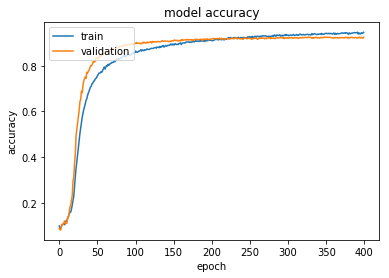

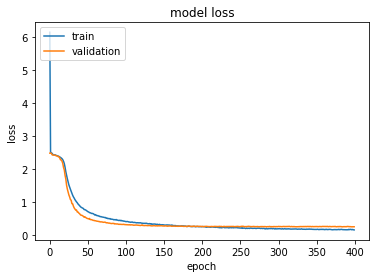

In [33]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test the model

In [34]:
model.load_weights('weights.hdf5')

In [35]:
y_predictions = [np.argmax(model.predict(np.expand_dims(example,axis=0))) for example in X_test.reshape(X_test.shape[0],20,40,1)]

accuracy =100*np.sum(np.array(y_predictions)==np.argmax( to_categorical(y_test),axis=1))/len(y_predictions)

print ('test accurac : %.4f%%' % accuracy)

test accurac : 92.1280%


# result visualization

Confusion matrix, without normalization
[[633  11  12   1   1   2  20   1   1   0   3   2]
 [ 18 651   9   2   4   4  40   4   3   0   4   0]
 [ 17   9 580  13  23  13  10   5  13   0  13   9]
 [  0   6   6 668   9   2   2  18   3   2   4   1]
 [  2   2  22   3 656   2   1  21   4   2   3   0]
 [  1   4  16   2   2 637   5   1   8   1   2  11]
 [ 22  44  10   2   1   4 653   3   1   0   2   3]
 [  2   3   8  18  10   4   0 642   2   1   1   0]
 [  1   5  15   2   3   5   2   0 698   0   1   1]
 [  0   0   0   0   0   0   0   0   0 612   0   0]
 [  4   9  11   4   1   0   1   3   1   0 692   0]
 [  4   2   5   0   0   3   2   1   1   0   1 649]]
Normalized confusion matrix
[[ 0.92  0.02  0.02  0.    0.    0.    0.03  0.    0.    0.    0.    0.  ]
 [ 0.02  0.88  0.01  0.    0.01  0.01  0.05  0.01  0.    0.    0.01  0.  ]
 [ 0.02  0.01  0.82  0.02  0.03  0.02  0.01  0.01  0.02  0.    0.02  0.01]
 [ 0.    0.01  0.01  0.93  0.01  0.    0.    0.02  0.    0.    0.01  0.  ]
 [ 0.    0.    0.03

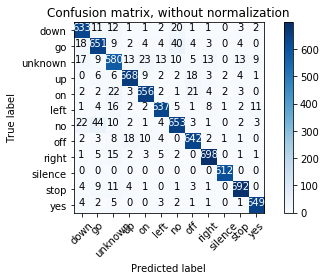

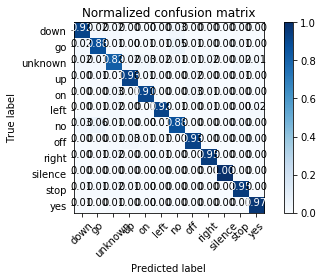

In [36]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #p.savefig('conf.png')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax( to_categorical(y_test),axis=1), np.array(y_predictions))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pl=plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl1=plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
pl.savefig('confusion.png')
pl1.savefig('confusion1.png')


# Prepare Kaggle submission

In [37]:
def test (path):
    #path=r"C:\Users\abdal_000\Downloads\data-set\test\audio\clip_0a77ea19a.wav"
    mfcc_feature=convert_wave_to_mfcc(path)
    #print(mfcc_feature.shape)
    
    pre=model.predict(mfcc_feature.reshape(1,20,40,1))
    return np.argmax(pre)

In [ ]:
import csv
audfiles=os.listdir(r"C:\Users\abdal_000\Downloads\data-set\test\audio")
print (audfiles[0])
with open('sample_submission.csv', 'w', newline='') as csvfile:
    fieldnames=['fname','label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    for audio in audfiles:
        pred = test(r"C:\Users\abdal_000\Downloads\data-set\test\audio\\"+audio)
        writer.writerow({'fname':audio,'label':labels[pred]})
    